In [2]:
import os
from collections import defaultdict
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mlp

FONTDICT = {
    'family': 'serif', 
    'color': 'black', 
    'weight': 'normal', 
    'size': 12
}

In [3]:
def get_results(dataset, models):

    valid_models = set(models)
    results = defaultdict(list)

    for model in valid_models.copy():

        exp_dir = f'./results/{dataset}/{model}'

        if not os.path.isdir(exp_dir):
            valid_models.discard(model)
            continue

        run_dir = f'{exp_dir}'
        results[model].append(dict())
        for split in ('training', 'validation'):
            fn = f'{run_dir}/{split}_results.pkl'
            if os.path.isfile(fn):
                with open(fn, 'rb') as f:
                    results[model][-1][split] = dict(pickle.load(f))
        if not results[model][-1]:
            results[model].pop()

        runs = os.listdir(exp_dir)
        if len(runs) != 5:
            print(f'{len(runs)} total runs: dataset {dataset}, model {model}')
        for run in runs:
            run_dir = f'{exp_dir}/{run}'
            if os.path.isdir(run_dir):
                results[model].append(dict())
                for split in ('training', 'validation'):
                    fn = f'{run_dir}/{split}_results.pkl'
                    if os.path.isfile(fn):
                        with open(fn, 'rb') as f:
                            results[model][-1][split] = dict(pickle.load(f))
                if not results[model][-1]:
                    results[model].pop()
        if len(results[model]) != 5:
            print(f'{len(results[model])} valid runs: dataset {dataset}, model {model}')
    
    return dict(results), tuple(valid_models)

def loss(data, idxs, jump):
    ys = list()
    for idx in idxs:
        loss = sum(data['loss'][idx-jump:idx])
        tp, tn, fp, fn = (
            sum(data['tp'][idx-jump:idx]),
            sum(data['tn'][idx-jump:idx]),
            sum(data['fp'][idx-jump:idx]),
            sum(data['fn'][idx-jump:idx]),
        )
        ys.append(loss / (tp+tn+fp+fn))
    return ys

def accuracy(data, idxs, jump):
    ys = list()
    for idx in idxs:
        tp, tn, fp, fn = (
            sum(data['tp'][idx-jump:idx]),
            sum(data['tn'][idx-jump:idx]),
            sum(data['fp'][idx-jump:idx]),
            sum(data['fn'][idx-jump:idx]),
        )
        acc = (tp+tn) / (tp+tn+fp+fn)
        ys.append(acc)
    return ys

def f1_score(data, idxs, jump):
    ys = list()
    for idx in idxs:
        tp, fp, fn = (
            sum(data['tp'][idx-jump:idx]),
            sum(data['fp'][idx-jump:idx]),
            sum(data['fn'][idx-jump:idx]),
        )
        f1 = (tp+tp) / (tp+tp+fp+fn)
        ys.append(f1)
    return ys

fn_map = {
    'Loss': loss,
    'Accuracy': accuracy,
    'F1-Score': f1_score
}

models = ['ALBERT', 'BERT', 'BERTweet', 'CT-BERT', 'DistilBERT', 'Longformer', 'RoBERTa', 'Twitter-RoBERTa', 'XLM', 'XLM-RoBERTa', 'XLNet',]

pairs = (
    ('CT-BERT', 'Twitter-RoBERTa'), 
    ('CT-BERT-NT', 'Twitter-RoBERTa-NT'), 
    ('CT-BERT', 'CT-BERT-NT'), 
    ('Twitter-RoBERTa', 'Twitter-RoBERTa-NT'),
)

In [4]:
def pairwise_plot(dataset, results, pairs, split, metric, jump, sep='/'):

    for k1, k2 in pairs:

        plt.figure(figsize=(6, 4))
        plt.xlabel('Batches Trained', fontdict=FONTDICT, labelpad=12)
        plt.ylabel(metric, fontdict=FONTDICT, labelpad=12)
        if metric.lower() == 'loss':
            plt.ticklabel_format(axis='both', style='sci', scilimits=(0, 0))
        else:
            plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

        data = results[k1][split]
        idxs = list(range(jump, len(data['batch'])+jump, jump))
        xs = [data['batch'][min(idx, len(data['batch']))-1] for idx in idxs]
        ys = fn_map[metric](data, idxs, jump)
        plt.plot(xs, ys, label=k1)

        data = results[k2][split]
        ys = fn_map[metric](data, idxs, jump)
        plt.plot(xs, ys, label=k2)

        plt.legend()
        plt.grid()

        fn = f'./assets/{dataset}{sep}{k1}_{k2}{sep}{split}{sep}{metric.lower()}.png'
        if not os.path.exists(os.path.dirname(fn)):
            os.makedirs(os.path.dirname(fn))
        plt.savefig(fn, bbox_inches='tight')
        plt.close()

In [5]:
# dataset = 'aaai-constraint-covid'
# jump = 50

# results, valid_pairs = get_results(dataset, pairs)

# for split, jump in (('training', 50), ('validation', 1)):
#     for metric in ('Loss', 'Accuracy', 'F1-Score'):
#         pairwise_plot(dataset, results, valid_pairs, split, metric, jump, sep='/')

In [6]:
datasets = (
    'aaai-constraint-covid',
    'aaai-constraint-covid-appended',
    # 'aaai-constraint-covid-cleaned',
    # 'aaai-constraint-covid-cleaned-appended',
    # 'covid-misinformation',
)

index = sorted(models) # + [model+'-NT' for model in models])
split = 'validation'
metric = 'Accuracy'
jump = 600 if split == 'training' else 1

dataframe = defaultdict(list)

for dataset in datasets:
    col_name = dataset.replace('aaai-constraint-covid', 'acc')
    results, _ = get_results(dataset, index)
    for model in index:
        if model in results:
            scores = list()
            for run in results[model]:
                data = run[split]
                idxs = list(range(jump, len(data['batch'])+jump, jump))
                ys = fn_map[metric](data, idxs, jump)
                scores.append(max(ys))
            # dataframe[col_name].append(f'{100*np.mean(scores):.4f} \pm {100*np.std(scores):.4f}')
            dataframe[col_name].append(f'{100*(1-np.mean(scores)):.3f} \pm {100*np.std(scores):.3f}')
        else:
            dataframe[col_name].append(np.nan)

df = pd.DataFrame(dataframe, index=index)
# df['improvement'] = 100*(df['acc']-df['acc-appended']) / df['acc']

df.style.set_properties(**{'text-align': 'right'})

,acc,acc-appended
ALBERT,3.336 \pm 0.255,3.206 \pm 0.166
BERT,3.159 \pm 0.113,2.953 \pm 0.116
BERTweet,2.953 \pm 0.091,2.916 \pm 0.140
CT-BERT,1.925 \pm 0.080,1.841 \pm 0.147
DistilBERT,2.617 \pm 0.078,2.766 \pm 0.143
Longformer,3.028 \pm 0.130,3.009 \pm 0.087
RoBERTa,2.991 \pm 0.203,2.953 \pm 0.116
Twitter-RoBERTa,2.879 \pm 0.152,2.925 \pm 0.188
XLM,2.907 \pm 0.302,3.056 \pm 0.070
XLM-RoBERTa,2.579 \pm 0.127,2.523 \pm 0.098


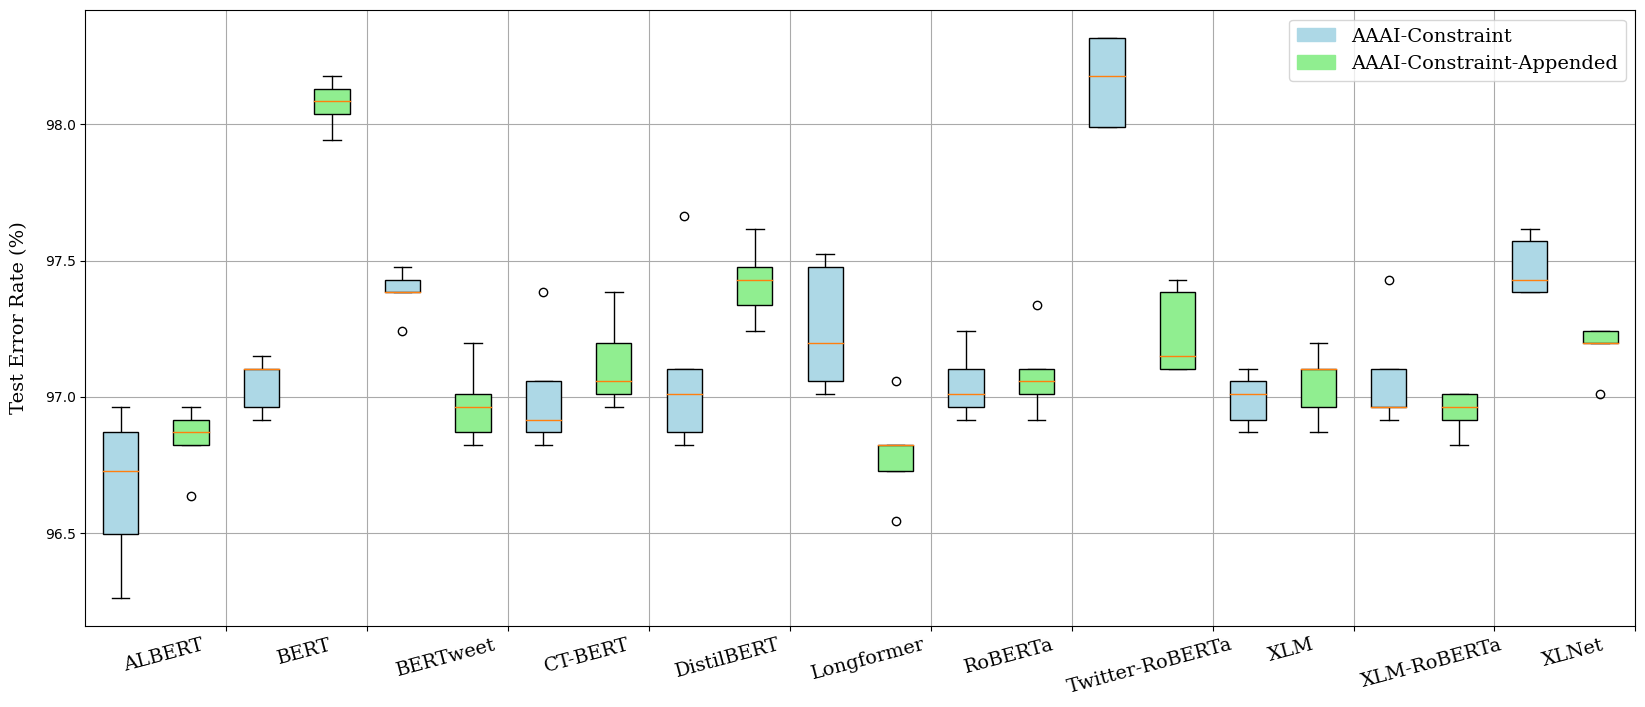

In [9]:
bplot_data = list()

for dataset in datasets:
    results, _ = get_results(dataset, index)
    for model in index:
        scores = list()
        for run in results[model]:
            data = run[split]
            idxs = list(range(jump, len(data['batch'])+jump, jump))
            ys = fn_map[metric](data, idxs, jump)
            scores.append(100*max(ys))
        bplot_data.append(scores)

fig, axs = plt.subplots(1, 1, figsize=(20, 8))
bplot = axs.boxplot(bplot_data, patch_artist=True)
colors = ['lightblue', 'lightgreen']
for i, patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[i%2])
fontdict = {'family':'serif', 'color':'black', 'weight':'normal', 'size':14}
axs.set_ylabel('Test Error Rate (%)', fontdict=fontdict, labelpad=12)
plt.xticks(ticks=np.arange(2.5, 23, 2), labels=index, rotation=15, **fontdict)
dx = -45/72.; dy = 0/72. 
offset = mlp.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in axs.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)
axs.grid(which='major', color='#AAAAAA', linewidth=0.8)
acc = mlp.patches.Patch(color='lightblue', label='AAAI-Constraint')
acc_a = mlp.patches.Patch(color='lightgreen', label='AAAI-Constraint-Appended')
plt.legend(handles=[acc, acc_a], prop={'family':'serif', 'size': 14})
plt.show()